# Project 3
## Non-parametric methods 
In this task, we decided to perform classification on the "Alive-At1" variable which represents if patients are still alive one year after their first heart attack. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

### Load data 

In [2]:
X_train = pd.read_csv("minmax_scaled_x_train.csv") # already normalized
X_test = pd.read_csv("minmax_scaled_x_test.csv") # already normalized
y_train = pd.read_csv("Y_train.csv")
y_test = pd.read_csv("Y_test.csv")


As seen in the last lab, "Survival" which represents the duration the patient have survived after the heart attack and "Still-Alive" if the patient is still alive at the time of the study, represent too much information. A real-world model would just work based on the clinical parameters. As a consequence, we decided to remove them from the dataset. 

In [3]:
# get rid of survival and still-alive column in data 
X_train = X_train.drop(columns=['Survival', 'Still-Alive'])
X_test = X_test.drop(columns=['Survival', 'Still-Alive'])

In [4]:
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
X.head()

,Age-At-Heart-Attack,Pericardial-effusion,Fractional-Shortening,EPSS,LVDD,Wall-Motion-Score,Wall-Motion-Index
0,0.854876,0.0,0.238095,0.695652,0.282230,0.677419,0.601504
1,0.716993,0.0,0.833333,0.260870,0.236934,0.419355,0.526316
2,0.634263,1.0,0.425372,0.498555,0.548921,0.722590,0.475939
3,0.710926,0.0,0.389048,0.215909,0.620176,0.019677,0.146618
4,0.736608,0.0,0.469317,0.565324,0.917483,0.007061,0.392318


In [5]:
y.head()

,Alive-At1
0,1.0
1,0.0
2,1.0
3,1.0
4,1.0


In [6]:
y_train = y_train.values.reshape(-1, 1).ravel() # to avoid errors
y_test = y_test.values.reshape(-1, 1).ravel() # to avoid errors

### Grid search and plot result functions

In [7]:
from sklearn.model_selection import GridSearchCV
from utils import analyze_train_test_performance, get_train_test_performances 

# These are customized functions: should be in utils.py
def hyper_parameters_search(clf, X, y, param_grid, scorer = 'f1', cv=5):
    
    grid = GridSearchCV(clf, param_grid = param_grid, scoring = scorer, cv = cv)
    grid.fit(X, y)

    print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
    print("best parameters: {}".format(grid.best_params_))
    
    return grid

def plot_cv_scoring(grid, hyper_parameter, scorer = 'f1', plot_errors = False, log=False):
    
    scores = np.array(grid.cv_results_['mean_test_score'])
    std_scores = grid.cv_results_['std_test_score']
    params = grid.param_grid[hyper_parameter]
    
    if log:
        params = np.log10(params)
    if plot_errors:
        plt.errorbar(params,scores,yerr=std_scores, fmt='o-',ecolor='g')
    else:
        plt.plot(params,scores, 'o-')
    plt.xlabel(hyper_parameter,fontsize=14)
    plt.ylabel(scorer)
    plt.show()
    
# feature importance
def plot_importances(importances, feat_names):
    
    df_importances = pd.Series(importances, index=feat_names)
    
    plt.figure()
    df_importances.plot.bar()
    plt.ylabel("Feature Importance")
    plt.show()

### K-NN
In K-NN, K represents the number of cluster used. The idea is to assign the class label that is most frequent among the k-nearest neighbors to the test observation. In other words, the target value for the test observation is the majority class among its k-nearest neighbors.

K can be selected by computing metrics over different k values and use cross validation to see which one produces the best score. 

When k is small, the model becomes more sensitive to noise and local fluctuations in the training data. The decision boundaries are more flexible and may follow the training data closely. This can lead to overfitting, where the model captures the noise in the training set, resulting in poor generalization to new, unseen data. The model may be too complex and fail to capture the underlying patterns. On the other hand, when k is large, the model's decision boundaries become smoother and less sensitive to individual data points. The model tends to generalize better because it relies on a larger number of neighbors, leading to a more stable prediction. However, if k is too large, the model may oversimplify and miss important patterns in the data, resulting in underfitting.

K-NN relies on the calculation of distances between data points. If the features are on different scales, features with larger magnitudes may dominate the distance computations. This sensitivity to scale can result in misleading distance measurements and affect the overall performance of the k-NN algorithm. 

During cross-validation, k=3 is the best classifier in terms of recall scoring whereas k=2 is the best in term of f1-score. Let's see the associated results on test set. k=3 performances on test set are ACC:88.24; SEN:100.00 and ESP:71.43 whereas they are ACC:94.12; SEN:100.00; ESP:85.71 with k=2. Knowing that are our classes are balanced, we can trust accuracy metric. Anyway, k=2 has better generalisation (better accuracy and specificity and equal sensivity)

best mean cross-validation score: 0.867
best parameters: {'n_neighbors': 1}


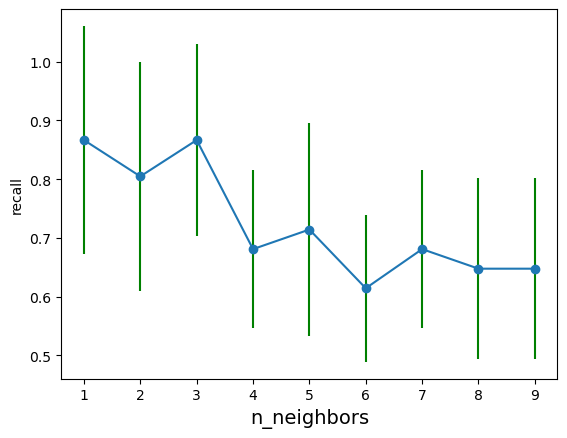

In [8]:
from sklearn.neighbors import KNeighborsClassifier

# Metric for the scoring
scorer = 'recall' 
param_grid = {'n_neighbors': range(1,10)}

estimator = KNeighborsClassifier()

# param_grid
grid_knn = hyper_parameters_search(estimator, X_train, y_train, param_grid, scorer=scorer, cv=5)

# do the plotting
plot_cv_scoring(grid_knn,'n_neighbors', scorer, plot_errors=True)

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	100.00	94.12
SEN:	100.00	100.00
ESP:	100.00	85.71
PPV:	100.00	90.91
F1:	100.00	95.24


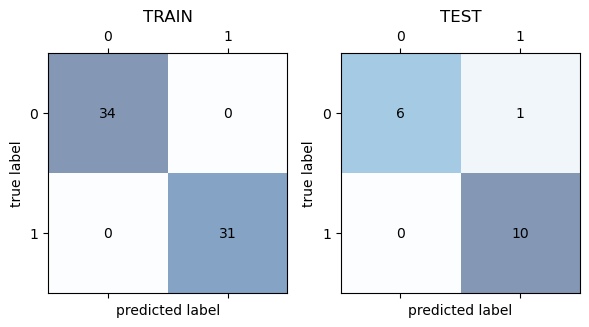

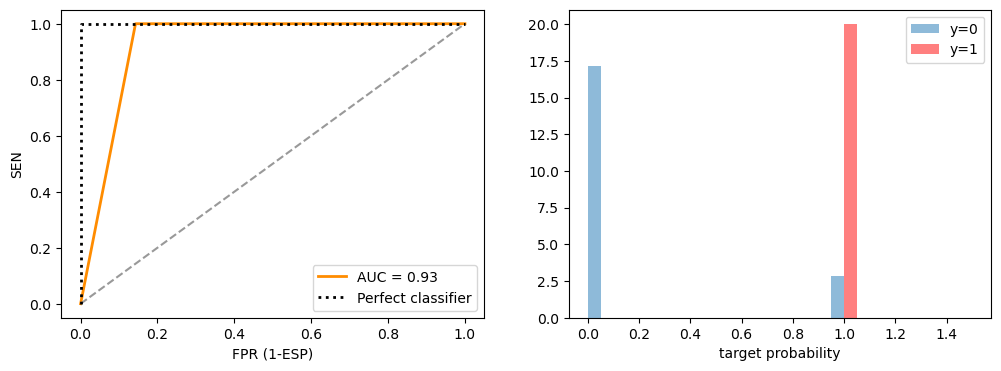

In [9]:
knn_model = grid_knn.best_estimator_
knn_train_metrics = {}
knn_test_metrics = {}
analyze_train_test_performance(knn_model, X_train, X_test, y_train, y_test) 

best mean cross-validation score: 0.811
best parameters: {'n_neighbors': 2}


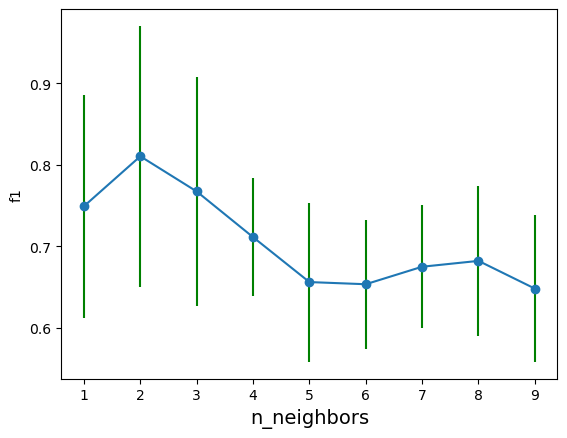

In [10]:
# Metric for the scoring
scorer = 'f1' 
param_grid = {'n_neighbors': range(1,10)}

estimator = KNeighborsClassifier()

# param_grid
grid_knn = hyper_parameters_search(estimator, X_train, y_train, param_grid, scorer=scorer, cv=5)

# do the plotting
plot_cv_scoring(grid_knn,'n_neighbors', scorer, plot_errors=True)

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	93.85	94.12
SEN:	87.10	100.00
ESP:	100.00	85.71
PPV:	100.00	90.91
F1:	93.10	95.24


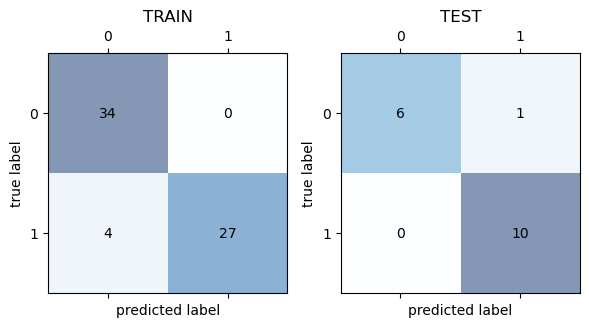

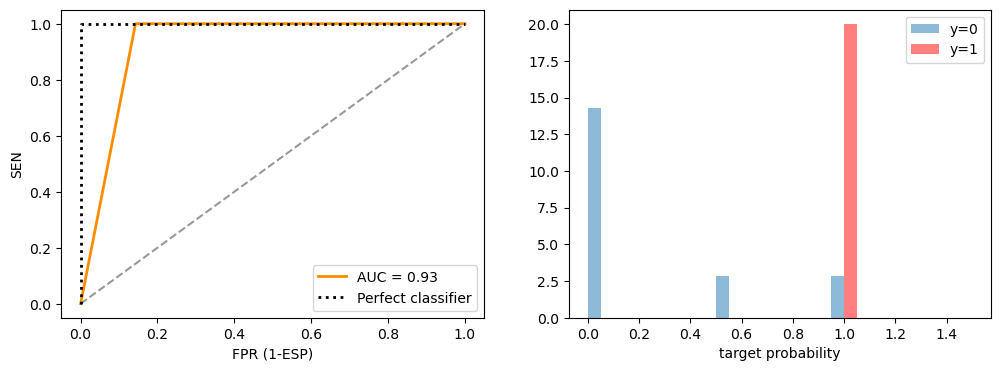

In [11]:
knn_model = grid_knn.best_estimator_
analyze_train_test_performance(knn_model, X_train, X_test, y_train, y_test) 

### Classification tree

We don't necesesarily have to normalize the data here. The tree makes decisions based on the relative ordering of features rather than their absolute values. However, we already did it in the preprocessing task so we will use normalized data. 

Inputs (X) are of length 65 so there is no interest in using minimum number of samples per node bigger than that.    

(65, 7)
best mean cross-validation score: 0.837
best parameters: {'min_samples_split': 7}


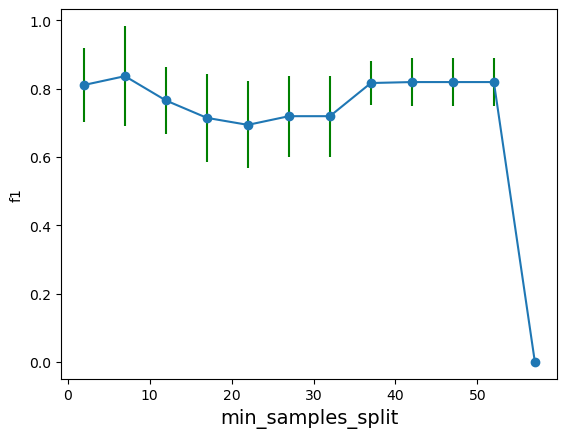

In [12]:
from sklearn.tree import DecisionTreeClassifier
print(X_train.shape)
# Decision trees
param_grid = {'min_samples_split': range(2, 60, 5)} # minimum number of samples required to split an internal node

scorer = 'f1'
estimator = DecisionTreeClassifier(random_state=0, criterion='gini') # we can the change the criterion to entropy 

#HYPER PARAMETER SEARCH
grid_dt = hyper_parameters_search(estimator, X_train, y_train, param_grid, scorer=scorer, cv=5)

# do the plotting
plot_cv_scoring(grid_dt,'min_samples_split',scorer, plot_errors=True)
dt_model = grid_dt.best_estimator_

best mean cross-validation score: 1.000
best parameters: {'min_samples_split': 42}


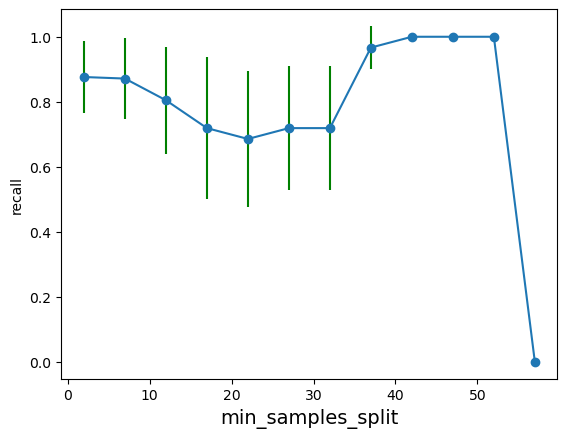

In [13]:
scorer = 'recall'

#HYPER PARAMETER SEARCH
grid_dt = hyper_parameters_search(estimator, X_train, y_train, param_grid, scorer=scorer, cv=5)

# do the plotting
plot_cv_scoring(grid_dt,'min_samples_split',scorer, plot_errors=True)
dt_model2 = grid_dt.best_estimator_

We do not get the same number of minimum number of samples required to split a node according to the scorer used for cross validation. Indeed, recall provides a much bigger number than f1-score (42 and 7 respectively). 

Let's analyze the decision tree model with 7 as minimum number of samples for split. 

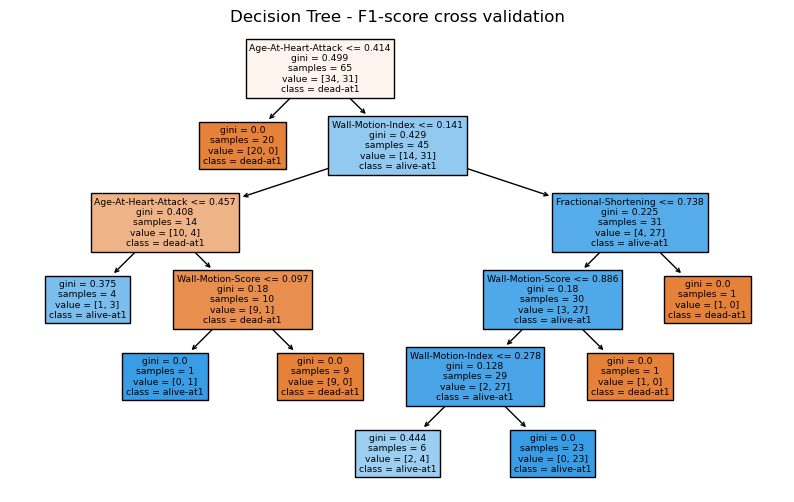

In [14]:
from sklearn.tree import plot_tree

# set plot dimensions
plt.figure(figsize=(10,6))

feature_names=X.columns # careful with what is X 

plot_tree(
    dt_model,
    feature_names=feature_names, 
    class_names=['dead-at1','alive-at1'], 
    filled=True
)
plt.title("Decision Tree - F1-score cross validation")
plt.show()

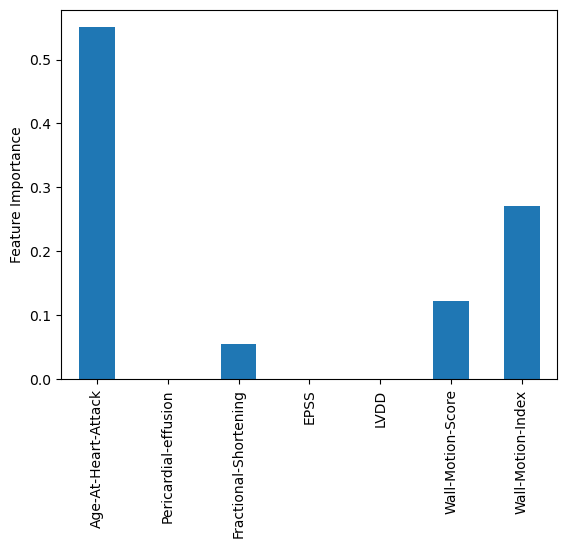

In [15]:
plot_importances(dt_model.feature_importances_, feature_names)

Let's analyze the decision tree model with 42 as minimum number of samples for split.

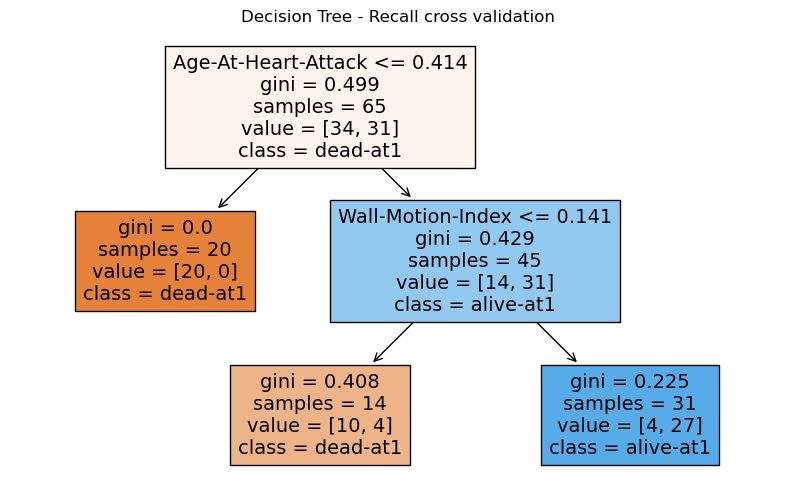

In [16]:
# set plot dimensions
plt.figure(figsize=(10,6))

feature_names=X.columns # careful with what is X 

plot_tree(
    dt_model2,
    feature_names=feature_names, 
    class_names=['dead-at1','alive-at1'], 
    filled=True
)
plt.title("Decision Tree - Recall cross validation")
plt.show()

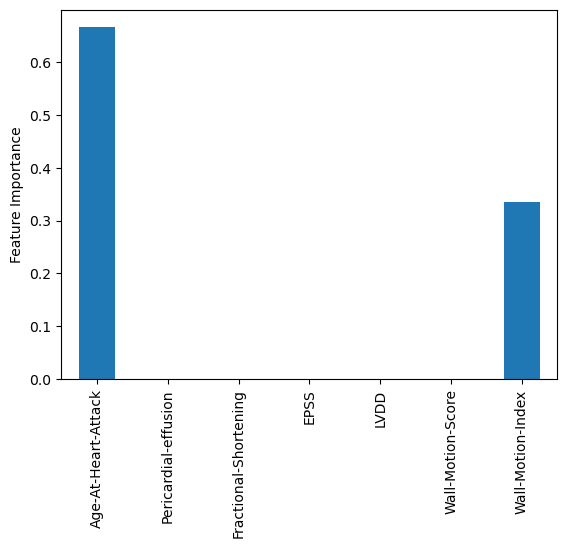

In [17]:
plot_importances(dt_model2.feature_importances_, feature_names)

The variable present on the nodes are only Age-at-Heart-Attack and Wall-Motion-Index (a clinical parameter) when choosing 42. However, they are much more when choosing 7. We think that choosing a too huge value creates a too smooth model that will not be able to generalize. 

Let's now compare the performances of the 2 models on the test set. 

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	95.38	88.24
SEN:	100.00	80.00
ESP:	91.18	100.00
PPV:	91.18	100.00
F1:	95.38	88.89


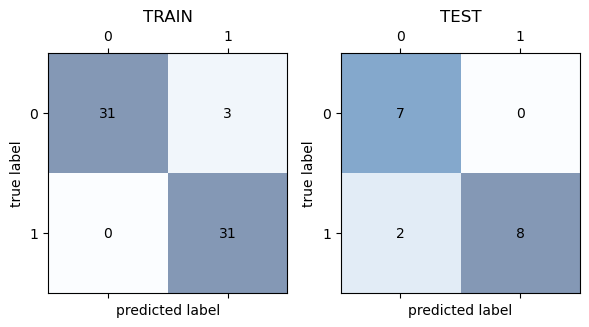

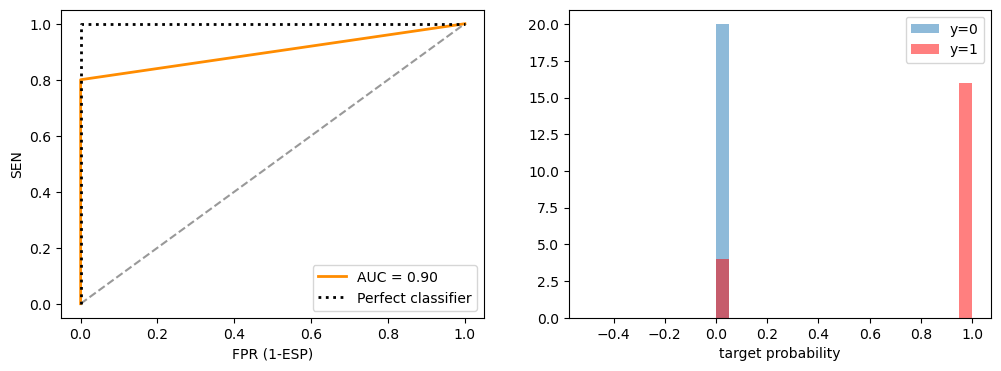

In [18]:
analyze_train_test_performance(dt_model, X_train, X_test, y_train, y_test) 

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	87.69	76.47
SEN:	87.10	70.00
ESP:	88.24	85.71
PPV:	87.10	87.50
F1:	87.10	77.78


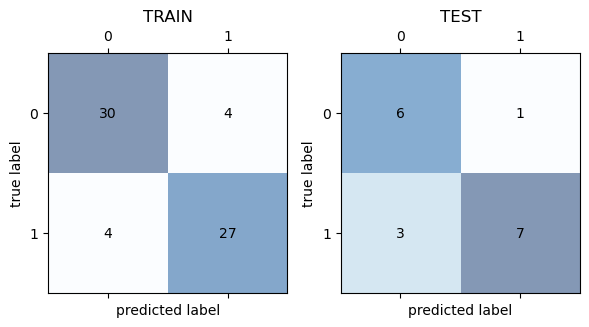

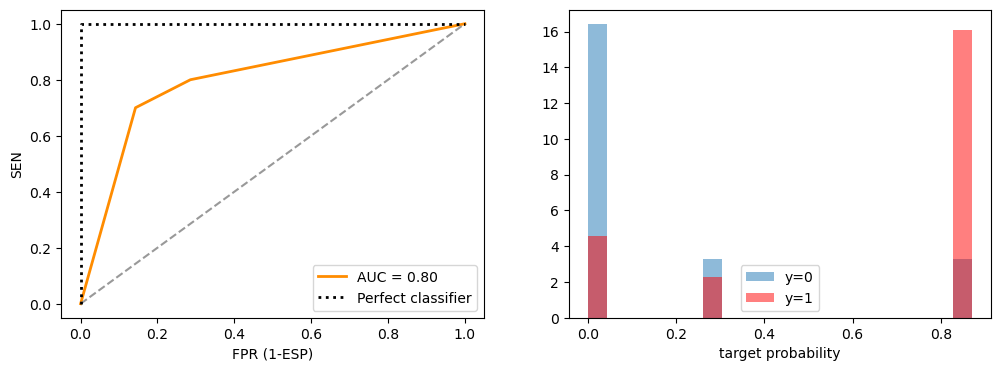

In [19]:
analyze_train_test_performance(dt_model2, X_train, X_test, y_train, y_test) 

Indeed, the model with 7 as minimum number of samples for splitting better generalizes. 

### Multi-layer perceptron



### Single hidden layer perceptron 
A neural network with a single hidden layer and one neuron has very limited capacity to learn complex patterns in the data.  Nevertheless, let's see how it performs. 

Here, data has to be normalized. Models optimized using gradient descent such as MLP, may converge faster when features are normalized. Normalization helps prevent large-range features from causing the optimization process to take longer when oscillating between values.

Model design: A maximum of 1000 iterations is set. When the loss or score is not improving by at least 1e-4 for 10 consecutive iterations, convergence is considered to be reached and training stops. The right regularization (L2), initial learning rate and batch size parameters have been found using a grid search scheme. The optimization is based on backpropagating f1 loss with Adam optimizer. Adam is a recent optimizer that also use ultimate and penultimate gradients, smoothing the optimization process. 


best mean cross-validation score: 0.813
best parameters: {'alpha': 0.01, 'hidden_layer_sizes': 91}
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	93.85	76.47
SEN:	90.32	70.00
ESP:	97.06	85.71
PPV:	96.55	87.50
F1:	93.33	77.78


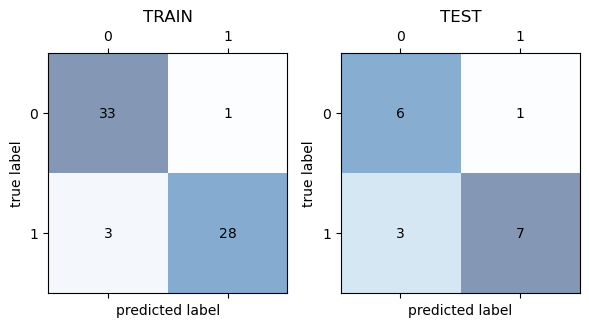

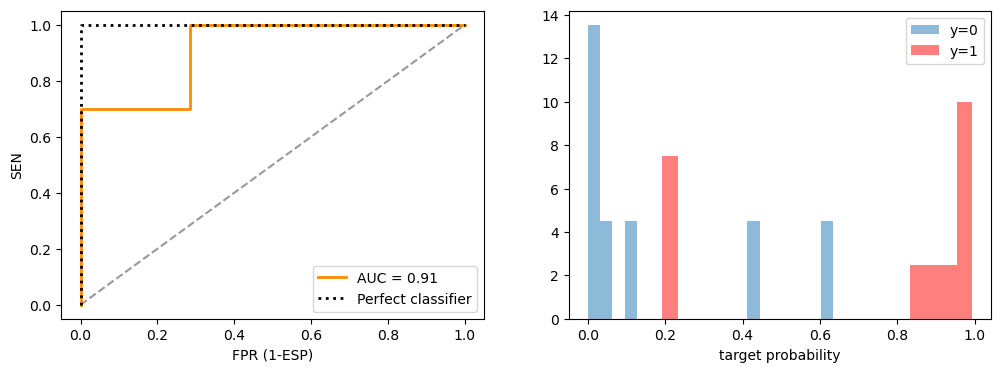

In [20]:
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

param_grid = {
    'alpha' : 10.0 ** -np.arange(2, 5), # regularization parameter
    'hidden_layer_sizes': np.arange(1, 100, 10), # number of hidden units
}
scorer = 'f1'
model = MLPClassifier(random_state=0, max_iter=1000, solver='adam')
grid_mlp = hyper_parameters_search(model, X_train, y_train, param_grid, scorer=scorer, cv=5)
mlp_model = grid_mlp.best_estimator_
analyze_train_test_performance(mlp_model, X_train, X_test, y_train, y_test) 

Accuracy, specificity and sensibility are 15-20% lower in test than training set. A lot of 1 labels are predicted as 0: our model is clearly under-fitting. 

Neural networks derive their power from the ability to learn hierarchical representations of features. With only one neuron, the network struggles to create diverse and informative representations of the eight features that we have. 

Here, we try to improve our network by using 100 hidden layers of 100 neurons each. Taking more did not provide better results. Also, a 'batch' learning scheme has been implemented using a batch size of 4 to 64. We also chose to gradually decrease the learning rate which begins at 1e-3.

In [21]:
warnings.filterwarnings('ignore')

param_grid = {
    'alpha' : 10.0 ** -np.arange(2, 5), 
    'batch_size': [4, 8, 16, 32, 64],
    'learning_rate_init': 10.0 ** -np.arange(2, 5),
}

model = MLPClassifier(random_state=0, max_iter=1000, hidden_layer_sizes=(100, 100), solver='adam', learning_rate='invscaling')
scorer = 'f1'

#hyper_parameters_search()
grid_mlp2 = hyper_parameters_search(model, X_train, y_train, param_grid, scorer=scorer, cv=5)


best mean cross-validation score: 0.920
best parameters: {'alpha': 0.001, 'batch_size': 8, 'learning_rate_init': 0.001}


PERFORMANCE METRICS
	TRAIN	TEST
ACC:	93.85	76.47
SEN:	90.32	70.00
ESP:	97.06	85.71
PPV:	96.55	87.50
F1:	93.33	77.78


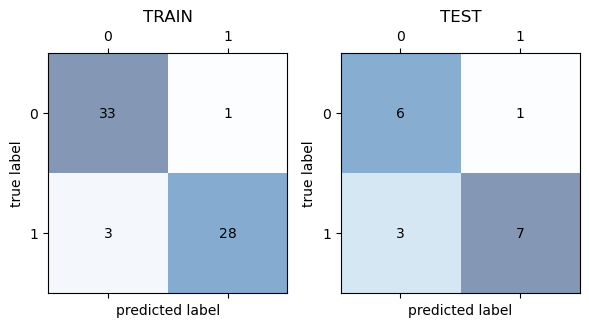

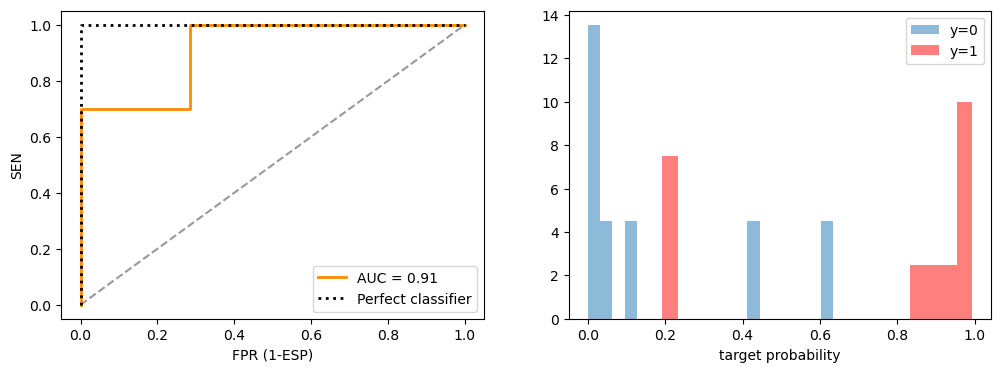

In [22]:
mlp_model2 = grid_mlp.best_estimator_
analyze_train_test_performance(mlp_model2, X_train, X_test, y_train, y_test) 

Using a (100, 100) shape for hidden layers provides a better f1-score on cross validation (0.905 vs 0.813) but does not produce better performances on the test dataset. 

## Random forest
As we are doing classification, we generate a forest of B decision trees whose predictions are combined by "voting" for a class. The final predicted class for a data point is determined by a majority vote from all the trees. As hyperparameters, there is the number of predictors which represent the number of trees used as candidates. We can also tune the maximum depth of the trees. 

In [23]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'max_depth': range(1, 20, 2)} # maximimum depth tuning

scorer = 'f1'
estimator = RandomForestClassifier(random_state=0, n_estimators=100) # we first fix the number of candidates (trees)

grid_rf = hyper_parameters_search(estimator, X_train, y_train, param_grid, scorer=scorer, cv=5)

best mean cross-validation score: 0.863
best parameters: {'max_depth': 5}


In [24]:
param_grid = {'n_estimators' : [25, 50, 100, 200]} # number of trees tuning
estimator = RandomForestClassifier(random_state=0, max_depth=5) # max_depth is fixed to the best value found in the previous step

grid_rf = hyper_parameters_search(estimator, X_train, y_train, param_grid, scorer=scorer, cv=5)

best mean cross-validation score: 0.863
best parameters: {'n_estimators': 50}


### Test the model

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	100.00	88.24
SEN:	100.00	80.00
ESP:	100.00	100.00
PPV:	100.00	100.00
F1:	100.00	88.89


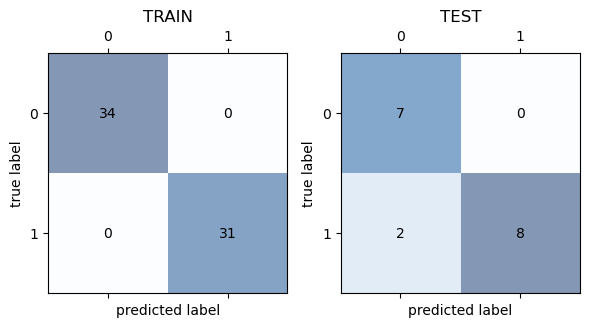

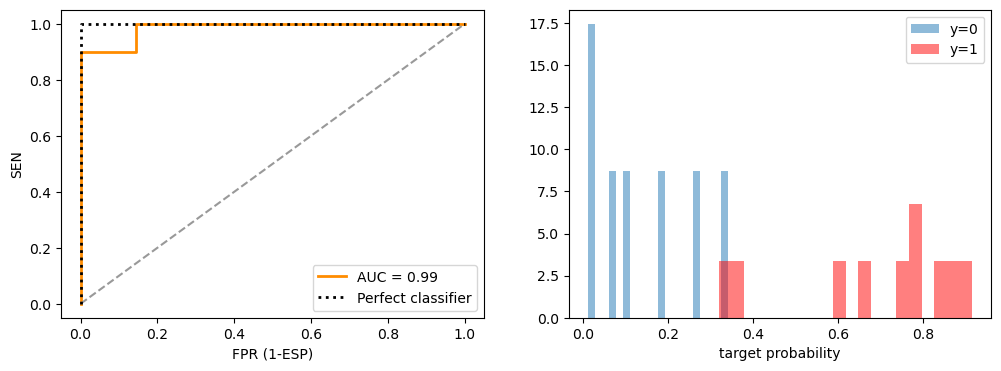

In [25]:
rf_model =  RandomForestClassifier(random_state=0, max_depth=5, n_estimators=50).fit(X_train, y_train)
analyze_train_test_performance(rf_model, X_train, X_test, y_train, y_test)

Our model achieves an AUC of 0.99 but seems to slightly underfit (2 FP) in the test set. 

## Model comparison

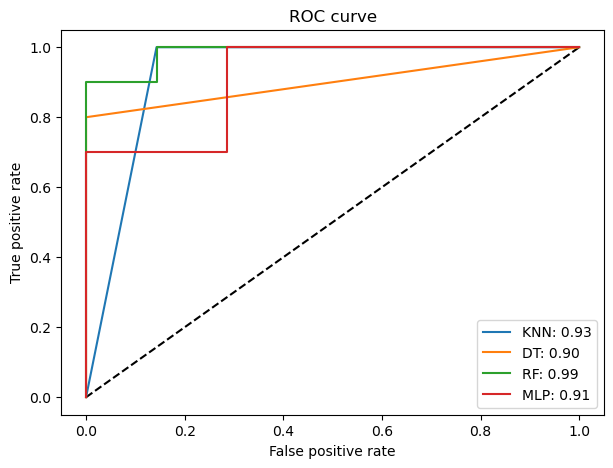

In [26]:
from sklearn.metrics import roc_curve, auc

models = {'KNN':knn_model, 'DT':dt_model, 'RF': rf_model, 'MLP': mlp_model}

plt.figure(figsize=(7,5))
plt.plot([0, 1], [0, 1], 'k--')
for k,v in models.items():
    fpr, tpr,_ = roc_curve(y_test, models[k].predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = k + ': %0.2f' % roc_auc)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [29]:
results = pd.DataFrame(columns=['Model', 'Train ACC', 'Train SEN',  'Train SPE', 'Train F1', 'Test ACC', 'Test SEN', 'Test SPE', 'Test F1'])


rf_train_metrics, rf_test_metrics = get_train_test_performances(rf_model, X_train, X_test, y_train, y_test)
dt_train_metrics, dt_test_metrics = get_train_test_performances(dt_model, X_train, X_test, y_train, y_test)
mlp_train_metrics, mlp_test_metrics = get_train_test_performances(mlp_model, X_train, X_test, y_train, y_test)
knn_train_metrics, knn_test_metrics = get_train_test_performances(knn_model, X_train, X_test, y_train, y_test)

results = results.append({'Model': 'RF', 'Train ACC': rf_train_metrics['acc'], 'Train SEN': rf_train_metrics['sen'], 'Train SPE': rf_train_metrics['esp'], 'Train F1': rf_train_metrics['fsc'], 'Test ACC': rf_test_metrics['acc'], 'Test SEN': rf_test_metrics['sen'], 'Test SPE': rf_test_metrics['esp'], 'Test F1': rf_test_metrics['fsc']}, ignore_index=True)
results = results.append({'Model': 'DT', 'Train ACC': dt_train_metrics['acc'], 'Train SEN': dt_train_metrics['sen'], 'Train SPE': dt_train_metrics['esp'], 'Train F1': dt_train_metrics['fsc'], 'Test ACC': dt_test_metrics['acc'], 'Test SEN': dt_test_metrics['sen'], 'Test SPE': dt_test_metrics['esp'], 'Test F1': dt_test_metrics['fsc']}, ignore_index=True)
results = results.append({'Model': 'MLP', 'Train ACC': mlp_train_metrics['acc'], 'Train SEN': mlp_train_metrics['sen'], 'Train SPE': mlp_train_metrics['esp'], 'Train F1': mlp_train_metrics['fsc'], 'Test ACC': mlp_test_metrics['acc'], 'Test SEN': mlp_test_metrics['sen'], 'Test SPE': mlp_test_metrics['esp'], 'Test F1': mlp_test_metrics['fsc']}, ignore_index=True)
results = results.append({'Model': 'KNN', 'Train ACC': knn_train_metrics['acc'], 'Train SEN': knn_train_metrics['sen'], 'Train SPE': knn_train_metrics['esp'], 'Train F1': knn_train_metrics['fsc'], 'Test ACC': knn_test_metrics['acc'], 'Test SEN': knn_test_metrics['sen'], 'Test SPE': knn_test_metrics['esp'], 'Test F1': knn_test_metrics['fsc']}, ignore_index=True)

results.head()

,Model,Train ACC,Train SEN,Train SPE,Train F1,Test ACC,Test SEN,Test SPE,Test F1
0,RF,1.000000,1.000000,1.000000,1.000000,0.882353,0.8,1.000000,0.888889
1,DT,0.953846,1.000000,0.911765,0.953846,0.882353,0.8,1.000000,0.888889
2,MLP,0.938462,0.903226,0.970588,0.933333,0.764706,0.7,0.857143,0.777778
3,KNN,0.938462,0.870968,1.000000,0.931034,0.941176,1.0,0.857143,0.952381


As a conclusion, random forest models achieves the best performances in terms of AUC and specificity, meaning that it predicts in a superior way the negative class (patients dead at 1 year). On the contrary, K-NN produces the best results in terms of accuracy, sensibility and F1-score, meaning that it genrally predicts well the different classes but most of all the positive class (patient alive at 1 year). Decision Tree model gets the same test results as Random Forest which can be explained by the fact that Random Forest is based on different trees. Multiple Layer Perceptron, achieving the worst results, seems to suffer from the low number of data. 